In [1]:
import numpy as np # linear algebra
run = 0
np.random.seed(run)
import os, glob
import time
import pyarrow as pa
import pyarrow.parquet as pq
import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from skimage.transform import rescale
plt.rcParams["figure.figsize"] = (5,5)
from torch.utils.data import *
from torch.utils.data import sampler

from scipy.stats import norm, semicircular
from sklearn import metrics

import ROOT

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator, FixedLocator
%matplotlib inline

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

Welcome to JupyROOT 6.24/06


In [2]:
lr_init = 5.e-4 #5.e-5
batch_size = 32#32
epochs = 60
ntrain = -1
gpuid = 0

#run_logger = False
run_logger = True

# Specify which gpuid to use
os.environ["CUDA_VISIBLE_DEVICES"]=str(gpuid)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # :0 is always first *visible* device
#device = torch.device("cpu")

In [3]:
class ParquetDataset(Dataset):
    def __init__(self, filename, scale=2.):
        self.parquet = pq.ParquetFile(filename)
        #self.cols = ['strain','y']
        self.cols = ['strain', 'y', 'dist', 'm1', 'm2']
        self.scale = scale
    def __getitem__(self, index):
        data = self.parquet.read_row_group(index, columns=self.cols).to_pydict()
        #data['strain'] = np.float32(np.ones(40960)).reshape(1,-1) #np.float32(data['strain'])*1.5
        data['strain'] = np.float32(data['strain'])/self.scale
        data['y'] = np.float32(data['y'])
        #data['y'] = np.int64(data['y'][0])
        data['dist'] = np.float32(data['dist'])
        data['m1'] = np.float32(data['m1'])
        data['m2'] = np.float32(data['m2'])
        return dict(data)
    def __len__(self):
        return self.parquet.num_row_groups

In [4]:
n_train = 72000
# Get parquet files
datadir = 'data/O1/parquet'
datadir = 'data/O1/parquet/m20to50_d1E2to5E2_2s'
#datadir = 'data/O1/parquet/m10to50_d5E2to1E3_2s'
pqfiles = glob.glob('%s/O1_local_N012_index0000_*.parquet'%datadir)
print(pqfiles)
dset_train = ConcatDataset([ParquetDataset(pqf) for pqf in pqfiles])

# Train set _______________________________________________________________________
# Take subset of training set, if desired
idxs = np.random.permutation(len(dset_train))
print(len(idxs))
if n_train != -1:
    assert n_train <= len(idxs)
    idxs_train = idxs[:n_train]
    idxs_val = idxs[n_train:]

# Create data loader
train_sampler = sampler.SubsetRandomSampler(idxs_train)
train_loader = DataLoader(dataset=dset_train, batch_size=batch_size, num_workers=4, pin_memory=True, sampler=train_sampler)

# Test set _______________________________________________________________________
val_sampler = sampler.SubsetRandomSampler(idxs_val)
val_loader = DataLoader(dataset=dset_train, batch_size=batch_size, num_workers=4, sampler=val_sampler)
print('len(train_loader):', len(train_loader))
print('len(val_loader):', len(val_loader))

['data/O1/parquet/m20to50_d1E2to5E2_2s/O1_local_N012_index0000_bg.parquet', 'data/O1/parquet/m20to50_d1E2to5E2_2s/O1_local_N012_index0000_sgbg.parquet']
84526
len(train_loader): 2250
len(val_loader): 392


In [5]:
def num2str(num):
    s = str('%3.2E'%num)
    s = s.replace('-','m')
    s = s.replace('+','p')
    return s

#expt_name = 'wave_resnet_total_acc_body_gyro_xyz_blocks3x3_lr%s_epochs%d_ntrain%3.fpc_run%d'\
#            %(num2str(lr_init), epochs, 100.*len(idxs_train)/len(dset_train), run)
expt_name = 'TEST'

if run_logger:
    if not os.path.isdir('LOGS'):
        os.makedirs('LOGS')
    f = open('LOGS/%s.log'%(expt_name), 'w')
    #for d in ['MODELS', 'METRICS','PLOTS']:
    for d in ['MODELS']:
        if not os.path.isdir('%s/%s'%(d, expt_name)):
            os.makedirs('%s/%s'%(d, expt_name))

def logger(s):
    global f, run_logger
    print(s)
    if run_logger:
        pass
        f.write('%s\n'%str(s))

logger('>> Experiment: %s'%(expt_name))
logger('>> N samples, train: %d'%(len(idxs_train)))
logger('>> N samples, test: %d'%(len(idxs_val)))

>> Experiment: TEST
>> N samples, train: 72000
>> N samples, test: 12526


In [6]:
class ResBlock(nn.Module):
    '''
    Basic resnet block
    '''
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ResBlock, self).__init__()
        
        self.debug = True
        self.debug = False
        
        self.downsample = out_channels//in_channels
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=self.downsample, padding=1)#, padding=(0,1) if self.downsample == 1 else 0)
        self.relu1 = nn.LeakyReLU() #nn.ReLU()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=1)# if self.downsample == 1 else 0)
        self.relu2 = nn.LeakyReLU() #nn.ReLU()
        self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=self.downsample)

    def forward(self, x):
        
        residual = x
        if self.debug: print('resblock, input:',x.size())

        out = self.conv1(x)
        if self.debug: print('resblock, after conv1:',out.size())
        out = self.relu1(out)
        out = self.conv2(out)
        if self.debug: print('resblock, after conv2:',out.size())

        if self.downsample > 1:
            residual = self.shortcut(x)
        
        if self.debug: print('resblock, shortcut:',residual.size())

        out += residual
        out = self.relu2(out)

        return out

class ResNet(nn.Module):

    def __init__(self, in_channels, nblocks, fmaps, kernel):
        super(ResNet, self).__init__()

        self.debug = True
        self.debug = False
        
        self.fmaps = fmaps
        self.nblocks = nblocks

        self.conv0 = nn.Conv1d(in_channels, fmaps[0], kernel_size=7, stride=1)#, padding=(0,1))
        self.layer1 = self.block_layers(self.nblocks, [fmaps[0],fmaps[0]], kernel)
        self.layer2 = self.block_layers(1, [fmaps[0],fmaps[1]], kernel)
        self.layer3 = self.block_layers(self.nblocks, [fmaps[1],fmaps[1]], kernel)
        self.layer4 = self.block_layers(1, [fmaps[1],fmaps[2]], kernel)
        self.layer5 = self.block_layers(self.nblocks, [fmaps[2],fmaps[2]], kernel)

        self.GlobalMaxPool1d = nn.AdaptiveMaxPool1d((1,))
        self.fc = nn.Linear(self.fmaps[-1], 1)
        
    def block_layers(self, nblocks, fmaps, kernel):
        layers = []
        for _ in range(nblocks):
            layers.append(ResBlock(fmaps[0], fmaps[1], kernel))
        return nn.Sequential(*layers)

    def forward(self, x):

        #if self.debug: print(x.size())
        # Reduce to 128 length
        x = F.max_pool1d(x, kernel_size=64)#/3.
        #if self.debug: print(x.size())
        # Run through ResNet
        if self.debug: print(x.size())
        x = self.conv0(x)
        if self.debug: print(x.size())
        x = F.leaky_relu(x)#F.relu(x)
        #x = F.max_pool2d(x, kernel_size=2)
        #if self.debug: print(x.size())

        x = self.layer1(x)
        if self.debug: print(x.size())
        x = self.layer2(x)
        if self.debug: print(x.size())
        x = self.layer3(x)
        if self.debug: print(x.size())
        x = self.layer4(x)
        if self.debug: print(x.size())
        x = self.layer5(x)
        if self.debug: print('pre-maxpool',x.size())
        
        x = self.GlobalMaxPool1d(x)
        if self.debug: print('post-maxpool',x.size())
        x = x.view(x.size()[0], self.fmaps[-1])
        if self.debug: print(x.size())
        # FC
        x = self.fc(x)
        if self.debug: print(x.size())

        return x

#fmaps = [4, 8, 16]
#fmaps = [8, 16, 32]
fmaps = [24, 48, 96]
model = ResNet(in_channels=1, nblocks=3, fmaps=fmaps, kernel=3)
model.to(device)#.cuda()
#optimizer = optim.Adam(model.parameters(), lr=lr_init)
optimizer = optim.Adamax(model.parameters(), lr=lr_init)

In [7]:
def do_eval(model, val_loader, epoch, best_auc, expt_name):
    
    eval_step = len(val_loader)//5 if len(val_loader) > 2 else 1
    loss = 0.
    neval = 0
    y_trues, y_preds, y_probs = [], [], []
    dists, m1s, m2s = [], [], []

    now = time.time()
    for i, data in enumerate(val_loader):
        X, y_true = data['strain'].to(device), data['y'].to(device)
        # Check for NaNs:
        nan_eles = torch.isnan(X).sum(2).view(-1)
        nan_rows = (nan_eles > 1)
        X, y_true = X[~nan_rows], y_true[~nan_rows]
        # Reduce to 128 length
        #X = F.max_pool1d(X, kernel_size=64)#/3.
        logits = model(X).to(device)

        loss += F.binary_cross_entropy_with_logits(logits, y_true).item() # loss will only converge to true mean in limit of identical batch sizes
        #loss += F.cross_entropy(logits, y_true).item() # loss will only converge to true mean in limit of identical batch sizes

        y_trues.append(y_true.tolist())
        #y_preds.append(torch.argmax(logits, dim=1).tolist()) # class pred only
        #y_probs.append(F.softmax(logits, dim=1).tolist()) # model output, normalized to (0,1)
        y_preds.append(logits.ge(0.).byte().tolist()) # class pred only
        y_probs.append(torch.sigmoid(logits).tolist()) # model output, normalized to (0,1)
        
        dist, m1, m2 = data['dist'][~nan_rows], data['m1'][~nan_rows], data['m2'][~nan_rows]
        dists.append(dist.tolist())
        m1s.append(m1.tolist())
        m2s.append(m2.tolist())

        neval += len(logits)
        if i % eval_step == 0:
            pass
            logger('%d: (%d/%d) ...'%(epoch, i, len(val_loader)))

    now = time.time() - now
    y_trues = np.concatenate(y_trues).squeeze()
    y_preds = np.concatenate(y_preds).squeeze()
    y_probs = np.concatenate(y_probs).squeeze()
    #print(y_true.shape, y_pred.shape, y_prob.shape)
    dists = np.concatenate(dists).squeeze()
    m1s = np.concatenate(m1s).squeeze()
    m2s = np.concatenate(m2s).squeeze()

    #acc = metrics.accuracy_score(y_true=y_trues.tolist(), y_pred=y_preds.tolist())
    fpr, tpr, _ = metrics.roc_curve(y_trues, y_probs) #y_preds)
    auc = metrics.auc(fpr, tpr)
    idx_fpr0 = np.argwhere(fpr==0.)[-1][0]
    tpr_fpr0 = tpr[idx_fpr0]
    logger('%d: Val time:%.2fs in %d steps for N:%d samples'%(epoch, now, len(val_loader), neval))
    logger('%d: Val loss:%f, auc:%f, TPR@FPR=0:%f'%(epoch, loss/len(val_loader), auc, tpr_fpr0)) # loss will only converge to true mean in limit of identical batch sizes

    #'''
    #if auc > best_auc:
        #best_acc = acc
    score_str = 'epoch%d_acc%.4f'%(epoch, acc)
    filename = 'MODELS/%s/model_%s.pkl'%(expt_name, score_str)
    model_dict = {'model': model.state_dict(), 'optim': optimizer.state_dict()}
    torch.save(model_dict, filename)
    #'''
        
    #return best_acc
    return auc, y_trues, y_preds, y_probs, dists, m1s, m2s, fpr, tpr, tpr_fpr0, loss/len(val_loader)

In [8]:
# Main training loop _______________________________________________________________________
best_auc = 0.5
print_step = len(train_loader)//10 if len(train_loader) > 5 else 1
#print_step = 100
logger(">> Training <<<<<<<<")
epochs = 50
#losses = []
aucs = []
tpr_fpr0s = []
losses = []

for e in range(epochs):

    epoch = e+1
    ntrained = 0
    logger('>> Epoch %d <<<<<<<<'%(epoch))

    # Run training
    model.train()
    now = time.time()
    for i, data in enumerate(train_loader):
        #print(len(data))
        #X, y_true_ = data
        #X, y_true = data[0].to(device), data[1].to(device)
        X, y_true = data['strain'].to(device), data['y'].to(device)
        # Check for NaNs:
        nan_eles = torch.isnan(X).sum(2).view(-1)
        #if nan_eles.sum() > 0:
        #    break
        nan_rows = (nan_eles > 1)
        X, y_true = X[~nan_rows], y_true[~nan_rows]
        # Reduce to 128 length
        #X = F.max_pool1d(X, kernel_size=64)#/3.
        #print(X.size(), y_true.size())
        #print('ytrue:', y_true.size(), y_true)
        #break
        optimizer.zero_grad()
        logits = model(X).to(device)
        #break

        #print(logits.size())
        #print('ypred:',y_pred.size(),y_pred)
        #loss = F.cross_entropy(logits, y).cuda()
        #loss = F.cross_entropy(logits, y_true).to(device)
        loss = F.binary_cross_entropy_with_logits(logits, y_true).to(device)
        #losses.append(loss.item())
        #print('loss',loss)
        #break
        loss.backward()
        optimizer.step()
        ntrained += len(logits)
        if i % print_step == 0:
            pass
            #y_pred = torch.argmax(logits, dim=1)
            y_pred = logits.ge(0.).byte()
            #print('ypred:',y_pred.size(),y_pred)
            #y_pred = F.softmax(logits, 1) # only if want output normalized to (0,1)
            #y_pred = torch.argmax(y_pred, dim=1)
            #print('ypred,softmax:',y_pred.size(),y_pred)
            acc = metrics.accuracy_score(y_true=y_true.tolist(), y_pred=y_pred.tolist())
            logger('%d: (%d/%d) y_true: %s...'%(epoch, i, len(train_loader), str(np.squeeze(y_true.tolist()[:5]))))
            logger('%d: (%d/%d) y_pred: %s...'%(epoch, i, len(train_loader), str(np.squeeze(y_pred.tolist()[:5]))))
            logger('%d: (%d/%d) train loss:%f, acc:%f'%(epoch, i, len(train_loader), loss.item(), acc))
        #break
        if torch.isnan(loss):
            break
    now = time.time() - now
    #y_pred = torch.argmax(logits, dim=1)
    y_pred = logits.ge(0.).byte()
    acc = metrics.accuracy_score(y_true=y_true.tolist(), y_pred=y_pred.tolist())
    logger('%d: Train time:%.2fs in %d steps for N:%d samples'%(epoch, now, len(train_loader), ntrained))
    logger('%d: Train loss:%f, acc:%f'%(epoch, loss.item(), acc))

    # Run Validation
    model.eval()
    logger('>> Validation <<<<<<<<')
    auc_, _, _, _, _, _, _, _, _, tpr_fpr0_, loss_ = do_eval(model, val_loader, epoch, best_auc)
    aucs.append(auc_)
    tpr_fpr0s.append(tpr_fpr0_)
    losses.append(loss_)

aucs = np.array(aucs)
tpr_fpr0s = np.array(tpr_fpr0s)
losses = np.array(losses)
logger('>> Best AUC:%f +/- %4.3f @ epoch:%d'%(np.max(aucs), best_auc/np.sqrt(len(idxs_val)), np.argwhere(aucs==np.max(aucs))[0][0]+1))
logger('>> Best TPR@FPR=0:%f @ epoch:%d'%(np.max(tpr_fpr0s), np.argwhere(tpr_fpr0s==np.max(tpr_fpr0s))[0][0]+1))

if run_logger:
    pass
    #f.close()
#'''

>> Training <<<<<<<<
>> Epoch 1 <<<<<<<<


/export/home/phys/mbandrews/miniconda3/envs/gw-pyt/lib/python3.6/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448272031/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


1: (0/2250) y_true: [0. 0. 1. 1. 1.]...
1: (0/2250) y_pred: [1 1 1 1 1]...
1: (0/2250) train loss:0.691864, acc:0.468750
1: (225/2250) y_true: [0. 1. 0. 1. 1.]...
1: (225/2250) y_pred: [0 1 0 1 0]...
1: (225/2250) train loss:0.155993, acc:0.937500
1: (450/2250) y_true: [0. 1. 0. 1. 1.]...
1: (450/2250) y_pred: [0 1 0 1 1]...
1: (450/2250) train loss:0.100806, acc:0.968750
1: (675/2250) y_true: [0. 1. 1. 1. 1.]...
1: (675/2250) y_pred: [0 1 1 1 1]...
1: (675/2250) train loss:0.023175, acc:1.000000
1: (900/2250) y_true: [0. 0. 1. 0. 1.]...
1: (900/2250) y_pred: [0 0 1 0 1]...
1: (900/2250) train loss:0.283310, acc:0.906250
1: (1125/2250) y_true: [1. 0. 0. 0. 0.]...
1: (1125/2250) y_pred: [0 0 0 0 0]...
1: (1125/2250) train loss:0.090622, acc:0.968750
1: (1350/2250) y_true: [0. 1. 0. 0. 0.]...
1: (1350/2250) y_pred: [0 1 0 0 0]...
1: (1350/2250) train loss:0.053748, acc:1.000000
1: (1575/2250) y_true: [0. 0. 1. 0. 0.]...
1: (1575/2250) y_pred: [0 0 1 0 0]...
1: (1575/2250) train loss:0.13

6: (225/2250) y_true: [1. 0. 1. 1. 1.]...
6: (225/2250) y_pred: [1 0 1 1 1]...
6: (225/2250) train loss:0.136659, acc:0.968750
6: (450/2250) y_true: [1. 0. 0. 1. 1.]...
6: (450/2250) y_pred: [1 0 0 1 1]...
6: (450/2250) train loss:0.083514, acc:0.968750
6: (675/2250) y_true: [1. 1. 0. 1. 0.]...
6: (675/2250) y_pred: [1 1 0 1 0]...
6: (675/2250) train loss:0.105377, acc:0.937500
6: (900/2250) y_true: [0. 0. 0. 0. 0.]...
6: (900/2250) y_pred: [0 0 0 0 0]...
6: (900/2250) train loss:0.026861, acc:1.000000
6: (1125/2250) y_true: [1. 1. 1. 1. 1.]...
6: (1125/2250) y_pred: [1 1 1 1 1]...
6: (1125/2250) train loss:0.092800, acc:0.968750
6: (1350/2250) y_true: [1. 1. 1. 0. 0.]...
6: (1350/2250) y_pred: [1 1 1 0 0]...
6: (1350/2250) train loss:0.020148, acc:1.000000
6: (1575/2250) y_true: [0. 0. 1. 0. 1.]...
6: (1575/2250) y_pred: [0 0 1 0 1]...
6: (1575/2250) train loss:0.029442, acc:1.000000
6: (1800/2250) y_true: [0. 0. 0. 1. 1.]...
6: (1800/2250) y_pred: [0 0 0 1 1]...
6: (1800/2250) train 

11: (450/2250) y_true: [0. 1. 1. 1. 0.]...
11: (450/2250) y_pred: [0 1 1 1 0]...
11: (450/2250) train loss:0.074795, acc:0.968750
11: (675/2250) y_true: [1. 1. 1. 0. 0.]...
11: (675/2250) y_pred: [1 1 1 0 0]...
11: (675/2250) train loss:0.070352, acc:0.968750
11: (900/2250) y_true: [1. 0. 1. 0. 0.]...
11: (900/2250) y_pred: [1 0 1 0 0]...
11: (900/2250) train loss:0.040937, acc:1.000000
11: (1125/2250) y_true: [0. 1. 0. 1. 1.]...
11: (1125/2250) y_pred: [0 1 0 0 1]...
11: (1125/2250) train loss:0.094800, acc:0.968750
11: (1350/2250) y_true: [0. 0. 0. 0. 1.]...
11: (1350/2250) y_pred: [0 0 0 0 1]...
11: (1350/2250) train loss:0.019708, acc:1.000000
11: (1575/2250) y_true: [0. 1. 1. 1. 1.]...
11: (1575/2250) y_pred: [0 1 1 1 1]...
11: (1575/2250) train loss:0.014699, acc:1.000000
11: (1800/2250) y_true: [1. 1. 0. 0. 1.]...
11: (1800/2250) y_pred: [1 0 0 0 1]...
11: (1800/2250) train loss:0.194284, acc:0.937500
11: (2025/2250) y_true: [1. 1. 1. 0. 1.]...
11: (2025/2250) y_pred: [1 1 1 0 1

16: (450/2250) y_true: [0. 1. 0. 1. 0.]...
16: (450/2250) y_pred: [0 1 0 0 0]...
16: (450/2250) train loss:0.102139, acc:0.968750
16: (675/2250) y_true: [0. 0. 0. 0. 0.]...
16: (675/2250) y_pred: [0 0 0 0 0]...
16: (675/2250) train loss:0.215818, acc:0.906250
16: (900/2250) y_true: [1. 1. 1. 1. 1.]...
16: (900/2250) y_pred: [1 1 1 1 0]...
16: (900/2250) train loss:0.366376, acc:0.875000
16: (1125/2250) y_true: [0. 1. 0. 0. 1.]...
16: (1125/2250) y_pred: [0 1 0 0 1]...
16: (1125/2250) train loss:0.140188, acc:0.906250
16: (1350/2250) y_true: [1. 1. 1. 1. 0.]...
16: (1350/2250) y_pred: [1 1 1 1 0]...
16: (1350/2250) train loss:0.016470, acc:1.000000
16: (1575/2250) y_true: [1. 1. 1. 1. 1.]...
16: (1575/2250) y_pred: [1 1 1 1 1]...
16: (1575/2250) train loss:0.096996, acc:0.968750
16: (1800/2250) y_true: [0. 0. 0. 1. 1.]...
16: (1800/2250) y_pred: [0 0 0 1 1]...
16: (1800/2250) train loss:0.240784, acc:0.937500
16: (2025/2250) y_true: [1. 0. 1. 0. 0.]...
16: (2025/2250) y_pred: [1 0 1 0 0

21: (450/2250) y_true: [1. 0. 0. 0. 1.]...
21: (450/2250) y_pred: [1 0 0 0 1]...
21: (450/2250) train loss:0.020354, acc:1.000000
21: (675/2250) y_true: [0. 1. 1. 0. 0.]...
21: (675/2250) y_pred: [0 1 0 0 0]...
21: (675/2250) train loss:0.109022, acc:0.968750
21: (900/2250) y_true: [0. 1. 0. 1. 1.]...
21: (900/2250) y_pred: [0 1 0 1 1]...
21: (900/2250) train loss:0.032752, acc:1.000000
21: (1125/2250) y_true: [0. 0. 1. 0. 0.]...
21: (1125/2250) y_pred: [0 0 1 0 0]...
21: (1125/2250) train loss:0.084954, acc:0.968750
21: (1350/2250) y_true: [1. 0. 1. 1. 1.]...
21: (1350/2250) y_pred: [1 0 1 0 1]...
21: (1350/2250) train loss:0.267492, acc:0.937500
21: (1575/2250) y_true: [1. 0. 0. 0. 0.]...
21: (1575/2250) y_pred: [1 0 0 0 0]...
21: (1575/2250) train loss:0.264597, acc:0.937500
21: (1800/2250) y_true: [0. 0. 0. 0. 1.]...
21: (1800/2250) y_pred: [0 0 0 0 1]...
21: (1800/2250) train loss:0.091679, acc:0.968750
21: (2025/2250) y_true: [0. 0. 0. 1. 1.]...
21: (2025/2250) y_pred: [0 0 0 1 1

26: (450/2250) y_true: [1. 0. 0. 1. 0.]...
26: (450/2250) y_pred: [1 0 0 1 0]...
26: (450/2250) train loss:0.043344, acc:0.968750
26: (675/2250) y_true: [0. 0. 1. 0. 0.]...
26: (675/2250) y_pred: [0 0 1 0 0]...
26: (675/2250) train loss:0.009980, acc:1.000000
26: (900/2250) y_true: [0. 1. 1. 0. 0.]...
26: (900/2250) y_pred: [0 1 1 0 0]...
26: (900/2250) train loss:0.033533, acc:1.000000
26: (1125/2250) y_true: [0. 1. 0. 0. 0.]...
26: (1125/2250) y_pred: [0 1 0 0 0]...
26: (1125/2250) train loss:0.025436, acc:1.000000
26: (1350/2250) y_true: [0. 0. 1. 1. 1.]...
26: (1350/2250) y_pred: [0 0 1 1 1]...
26: (1350/2250) train loss:0.020837, acc:1.000000
26: (1575/2250) y_true: [1. 1. 0. 0. 0.]...
26: (1575/2250) y_pred: [1 1 0 0 0]...
26: (1575/2250) train loss:0.106593, acc:0.968750
26: (1800/2250) y_true: [1. 1. 0. 1. 0.]...
26: (1800/2250) y_pred: [1 1 0 1 0]...
26: (1800/2250) train loss:0.039813, acc:1.000000
26: (2025/2250) y_true: [0. 1. 0. 0. 1.]...
26: (2025/2250) y_pred: [0 1 0 0 1

31: (450/2250) y_true: [1. 1. 1. 1. 0.]...
31: (450/2250) y_pred: [1 1 1 1 0]...
31: (450/2250) train loss:0.052668, acc:0.968750
31: (675/2250) y_true: [1. 1. 1. 0. 1.]...
31: (675/2250) y_pred: [1 1 1 0 1]...
31: (675/2250) train loss:0.120137, acc:0.968750
31: (900/2250) y_true: [1. 1. 0. 0. 0.]...
31: (900/2250) y_pred: [1 1 0 0 0]...
31: (900/2250) train loss:0.024129, acc:1.000000
31: (1125/2250) y_true: [1. 0. 1. 0. 1.]...
31: (1125/2250) y_pred: [1 0 1 0 1]...
31: (1125/2250) train loss:0.010887, acc:1.000000
31: (1350/2250) y_true: [1. 1. 0. 0. 0.]...
31: (1350/2250) y_pred: [1 1 0 0 0]...
31: (1350/2250) train loss:0.020399, acc:1.000000
31: (1575/2250) y_true: [0. 1. 0. 1. 1.]...
31: (1575/2250) y_pred: [0 1 0 1 1]...
31: (1575/2250) train loss:0.015144, acc:1.000000
31: (1800/2250) y_true: [1. 0. 0. 0. 0.]...
31: (1800/2250) y_pred: [1 0 0 0 0]...
31: (1800/2250) train loss:0.098892, acc:0.968750
31: (2025/2250) y_true: [0. 0. 0. 0. 1.]...
31: (2025/2250) y_pred: [0 0 0 0 1

36: (450/2250) y_true: [1. 0. 0. 1. 0.]...
36: (450/2250) y_pred: [1 0 0 1 0]...
36: (450/2250) train loss:0.064170, acc:0.968750
36: (675/2250) y_true: [1. 0. 0. 0. 1.]...
36: (675/2250) y_pred: [1 0 0 0 1]...
36: (675/2250) train loss:0.098394, acc:0.968750
36: (900/2250) y_true: [0. 1. 0. 1. 0.]...
36: (900/2250) y_pred: [0 1 0 1 0]...
36: (900/2250) train loss:0.036089, acc:0.968750
36: (1125/2250) y_true: [1. 0. 0. 1. 0.]...
36: (1125/2250) y_pred: [1 0 0 1 0]...
36: (1125/2250) train loss:0.078098, acc:0.968750
36: (1350/2250) y_true: [1. 1. 1. 0. 1.]...
36: (1350/2250) y_pred: [1 1 1 0 1]...
36: (1350/2250) train loss:0.098323, acc:0.968750
36: (1575/2250) y_true: [0. 0. 0. 0. 0.]...
36: (1575/2250) y_pred: [0 0 0 0 0]...
36: (1575/2250) train loss:0.155673, acc:0.968750
36: (1800/2250) y_true: [0. 1. 1. 0. 1.]...
36: (1800/2250) y_pred: [0 1 1 0 1]...
36: (1800/2250) train loss:0.024710, acc:1.000000
36: (2025/2250) y_true: [1. 1. 1. 0. 0.]...
36: (2025/2250) y_pred: [1 1 1 0 0

41: (450/2250) y_true: [0. 0. 0. 1. 0.]...
41: (450/2250) y_pred: [0 0 0 1 0]...
41: (450/2250) train loss:0.109275, acc:0.968750
41: (675/2250) y_true: [1. 0. 0. 1. 1.]...
41: (675/2250) y_pred: [1 0 0 1 1]...
41: (675/2250) train loss:0.135659, acc:0.968750
41: (900/2250) y_true: [0. 1. 0. 0. 0.]...
41: (900/2250) y_pred: [0 1 0 0 0]...
41: (900/2250) train loss:0.203850, acc:0.937500
41: (1125/2250) y_true: [1. 0. 1. 0. 1.]...
41: (1125/2250) y_pred: [1 0 1 0 1]...
41: (1125/2250) train loss:0.182098, acc:0.937500
41: (1350/2250) y_true: [1. 0. 1. 0. 1.]...
41: (1350/2250) y_pred: [1 0 1 0 1]...
41: (1350/2250) train loss:0.012135, acc:1.000000
41: (1575/2250) y_true: [1. 1. 0. 0. 1.]...
41: (1575/2250) y_pred: [1 1 0 0 1]...
41: (1575/2250) train loss:0.011958, acc:1.000000
41: (1800/2250) y_true: [0. 0. 0. 1. 0.]...
41: (1800/2250) y_pred: [0 0 0 1 0]...
41: (1800/2250) train loss:0.112342, acc:0.968750
41: (2025/2250) y_true: [1. 0. 1. 1. 1.]...
41: (2025/2250) y_pred: [1 0 1 1 1

46: (450/2250) y_true: [1. 1. 0. 0. 0.]...
46: (450/2250) y_pred: [1 1 0 0 0]...
46: (450/2250) train loss:0.062621, acc:0.968750
46: (675/2250) y_true: [1. 0. 0. 1. 1.]...
46: (675/2250) y_pred: [1 0 0 1 1]...
46: (675/2250) train loss:0.008190, acc:1.000000
46: (900/2250) y_true: [0. 1. 1. 1. 0.]...
46: (900/2250) y_pred: [0 1 1 1 0]...
46: (900/2250) train loss:0.445774, acc:0.906250
46: (1125/2250) y_true: [0. 0. 0. 0. 1.]...
46: (1125/2250) y_pred: [0 0 0 0 1]...
46: (1125/2250) train loss:0.148625, acc:0.937500
46: (1350/2250) y_true: [0. 1. 0. 0. 1.]...
46: (1350/2250) y_pred: [0 1 0 0 1]...
46: (1350/2250) train loss:0.075247, acc:0.968750
46: (1575/2250) y_true: [1. 0. 1. 0. 0.]...
46: (1575/2250) y_pred: [1 0 1 0 0]...
46: (1575/2250) train loss:0.024217, acc:1.000000
46: (1800/2250) y_true: [1. 1. 0. 0. 1.]...
46: (1800/2250) y_pred: [1 1 0 0 1]...
46: (1800/2250) train loss:0.258434, acc:0.937500
46: (2025/2250) y_true: [0. 0. 0. 0. 0.]...
46: (2025/2250) y_pred: [0 0 0 0 0

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

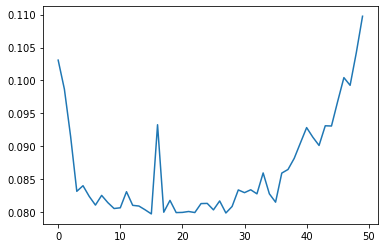

In [9]:
plt.plot(losses)
plt.show()

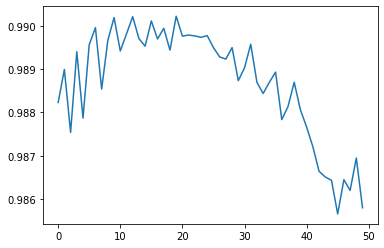

In [10]:
plt.plot(aucs)
plt.show()

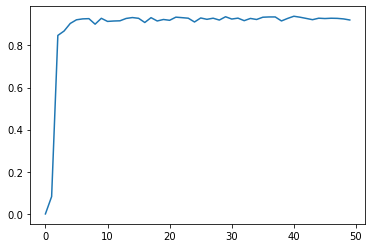

In [11]:
plt.plot(tpr_fpr0s)
plt.show()

In [64]:
auc, y_trues, y_preds, y_probs, dists, m1s, m2s, fpr, tpr, tpr_fpr0 = do_eval(model, train_loader, epoch, best_auc)
#auc, y_trues, y_preds, y_probs, dists, m1s, m2s, fpr, tpr, tpr_fpr0 = do_eval(model, val_loader, epoch, best_auc)

10: (0/2250) ...
10: (450/2250) ...
10: (900/2250) ...
10: (1350/2250) ...
10: (1800/2250) ...
10: Val time:76.66s in 2250 steps for N:71986 samples
10: Val loss:0.086737, auc:0.988463, TPR@FPR=0:0.706199


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


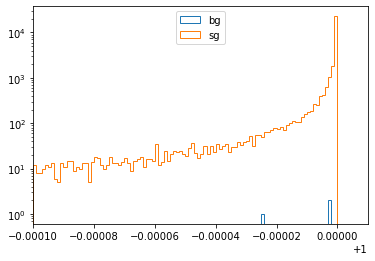

In [65]:
#print(y_trues.shape, y_probs.shape)
nbins=100
xrange = [0.9999, 1.]
plt.hist(y_probs[y_trues==0], histtype='step', range=xrange, bins=nbins, label='bg')
plt.hist(y_probs[y_trues==1], histtype='step', range=xrange, bins=nbins, label='sg')
plt.xlim([0.9999, 1.00001])
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper center')
plt.show()

4242
tpr: [0.         0.35110075 0.46428472 ... 0.99997224 1.         1.        ]
fpr: [0.         0.         0.         ... 0.99794244 0.99794244 1.        ]
thr: [2.         1.         0.99999988 ... 0.00890743 0.00890392 0.00745835]


/export/home/phys/mbandrews/miniconda3/envs/gw-pyt/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


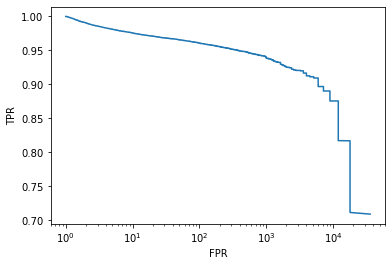

2.7804810232170165e-05
24 2.7804810232170165e-05 0.9999972581863403 0.7088642736181672
2.7804810232170165e-05
35965.0
4.555880064636805


In [66]:
# see: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
fpr, tpr, thr = metrics.roc_curve(y_trues, y_probs)
print(len(fpr))
print('tpr:', tpr)
print('fpr:', fpr)
print('thr:', thr)
plt.plot(1./fpr, tpr, label=r'AUC = %0.2f'%(auc)) #lw=2, alpha=.8))
#plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlabel('FPR')
plt.ylabel('TPR')
#plt.ylim([0.9, 1.01])
#plt.xlim([1.e3, 1./5.e-5])#1./5.56096205e-05])
plt.xscale('log')
plt.show()

# Get index just before FPR drops to 0
#idx = np.argwhere(fpr>1.e-4)[0]
fprmin = fpr[fpr>0.].min()
print(fprmin)
idx = np.argwhere(fpr>=fprmin)[0][0]
idx = np.argwhere(fpr==0.)[-1][0]+1
print(idx, fpr[idx], thr[idx], tpr[idx])
print(fpr[idx])
print(1./fpr[idx])
thr_fprinvmax = thr[idx]
# Get log equivalent of FPR min / FRPinv max
fprinv_max = 1./fpr[idx]
fprinv_logmax = np.log10(fprinv_max)
print(fprinv_logmax)

In [67]:
# Check that you can reproduce FPR values from metrics.roc_curve() using full list of thresholds

# fpr = fp / (fp + tn), where 
# fp = ground truth bkg, labelled as sg
# N = (fp + tn) = total number of ground truth bkg
sg_mask = (y_trues == 1)
bg_mask = (y_trues == 0)
y_probs_sg = y_probs[sg_mask]
y_probs_bg = y_probs[bg_mask]

nbg = len(y_probs_bg)*1.
fpr_test = []
for th in thr:
    fp = len(y_probs_bg[y_probs_bg>=th])*1.
    fpr_test.append(fp/nbg)
#fpr_test

np.array_equal(fpr, fpr_test)

True

In [68]:
# Now determine coarse-binned thresholds based on user-defined FPR values

# Specify user-defined FPR edges
# Set upper limit to value where FPR drops to 0
# i.e. value where 1./FPR is max
fpr_edges = 1./np.logspace(0, fprinv_logmax, num=6*2)
fpr_edges = np.concatenate([[0.], fpr_edges[::-1]])
#fpr_edges = fpr_edges[::-1]
print(fpr_edges)

# Get corresponding prob thresholds from full threshold list
# Get idxs
thr_idxs = np.array([np.argwhere(fpr>=e)[0][0] for e in fpr_edges])#+1
print('coarse idxs:',thr_idxs)
print('coarse FPRs:',fpr[thr_idxs])
print('coarse 1/FPRs:',1./fpr[thr_idxs])
print('coarse TPRs:',tpr[thr_idxs])
# Get prob thresholds
thr_coarse = thr[thr_idxs]
print('coarse prob thresh:',thr_coarse)

[0.00000000e+00 2.78048102e-05 7.21590572e-05 1.87267221e-04
 4.85995984e-04 1.26125702e-03 3.27321483e-03 8.49464874e-03
 2.20453166e-02 5.72120165e-02 1.48476653e-01 3.85326684e-01
 1.00000000e+00]
coarse idxs: [   0   24  197  916  945 1000 1122 1346 1670 1992 2467 3094 4241]
coarse FPRs: [0.00000000e+00 2.78048102e-05 8.34144307e-05 1.94633672e-04
 5.00486584e-04 1.27902127e-03 3.33657723e-03 8.50827193e-03
 2.21048241e-02 5.73057139e-02 1.48505491e-01 3.86041985e-01
 1.00000000e+00]
coarse 1/FPRs: [           inf 3.59650000e+04 1.19883333e+04 5.13785714e+03
 1.99805556e+03 7.81847826e+02 2.99708333e+02 1.17532680e+02
 4.52389937e+01 1.74502669e+01 6.73375772e+00 2.59039182e+00
 1.00000000e+00]
coarse TPRs: [0.         0.70886427 0.81696788 0.90933067 0.92521029 0.9428389
 0.95183365 0.95955137 0.96643625 0.97162766 0.97851253 0.98717415
 1.        ]
coarse prob thresh: [2.         0.99999726 0.99997509 0.99798214 0.98987854 0.90254813
 0.69908971 0.42515254 0.19583018 0.09086837 0

/export/home/phys/mbandrews/miniconda3/envs/gw-pyt/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


In [69]:
# Make Nsg,Nbg vs 1/FPR using reduced, user-defined set of thresholds

sg_mask = (y_trues == 1)
bg_mask = (y_trues == 0)
y_probs_sg = y_probs[sg_mask]
y_probs_bg = y_probs[bg_mask]

nbg = len(y_probs_bg)*1.

sg_thr = []
bg_thr = []
sg_thr.append(0)
bg_thr.append(0)
for i in range(1, len(thr_coarse)):
    print(i, thr_coarse[i-1], thr_coarse[i])
    sg_thr_mask = (y_probs_sg<=thr_coarse[i-1]) & (y_probs_sg > thr_coarse[i])
    sg_thr.append(len(y_probs_sg[sg_thr_mask]))
    bg_thr_mask = (y_probs_bg<=thr_coarse[i-1]) & (y_probs_bg > thr_coarse[i])
    bg_thr.append(len(y_probs_bg[bg_thr_mask]))
    #break

sg_thr = np.array(sg_thr)
bg_thr = np.array(bg_thr)

1 2.0 0.9999972581863403
2 0.9999972581863403 0.9999750852584839
3 0.9999750852584839 0.9979821443557739
4 0.9979821443557739 0.9898785352706909
5 0.9898785352706909 0.9025481343269348
6 0.9025481343269348 0.6990897059440613
7 0.6990897059440613 0.4251525402069092
8 0.4251525402069092 0.19583018124103546
9 0.19583018124103546 0.09086836874485016
10 0.09086836874485016 0.0429045669734478
11 0.0429045669734478 0.02291024476289749
12 0.02291024476289749 0.0074583482928574085


In [70]:
# Print values at coarse thresholds
print(fpr_edges)#[::-1])
print(1./fpr_edges)#[::-1])
print(sg_thr)#[::-1])
print(bg_thr)#[::-1])

[0.00000000e+00 2.78048102e-05 7.21590572e-05 1.87267221e-04
 4.85995984e-04 1.26125702e-03 3.27321483e-03 8.49464874e-03
 2.20453166e-02 5.72120165e-02 1.48476653e-01 3.85326684e-01
 1.00000000e+00]
[           inf 3.59650000e+04 1.38582742e+04 5.33996284e+03
 2.05763017e+03 7.92859811e+02 3.05510042e+02 1.17721171e+02
 4.53611086e+01 1.74788456e+01 6.73506560e+00 2.59520049e+00
 1.00000000e+00]
[    0 25438  3985  3332   572   635   324   278   248   187   248   312
   462]
[    0     0     2     4    11    28    74   186   489  1266  3280  8543
 22081]


/export/home/phys/mbandrews/miniconda3/envs/gw-pyt/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


/export/home/phys/mbandrews/miniconda3/envs/gw-pyt/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/export/home/phys/mbandrews/miniconda3/envs/gw-pyt/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


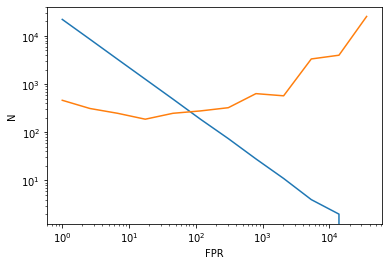

In [71]:
plt.plot(1./fpr_edges, bg_thr, label=r'AUC = %0.2f'%(auc)) #lw=2, alpha=.8))
plt.plot(1./fpr_edges, sg_thr, label=r'AUC = %0.2f'%(auc)) #lw=2, alpha=.8))
plt.xlabel('FPR')
plt.ylabel('N')
#plt.ylim([0.9, 1.01])
#plt.xlim([1.e2, 1./5.e-5])#1./5.56096205e-05])
plt.xscale('log')
plt.yscale('log')
plt.show()

In [72]:
'''
# Make Nsg,Nbg vs 1/FPR using full set of threshold values

sg_mask = (y_trues == 1)
bg_mask = (y_trues == 0)
y_probs_sg = y_probs[sg_mask]
y_probs_bg = y_probs[bg_mask]
print(y_probs_sg.max())
print(y_probs_bg.max())

sg_thr = []
bg_thr = []
sg_thr.append(0)
bg_thr.append(0)
for i in range(len(thr[1:])):
    sg_thr_mask = (y_probs_sg<thr[i-1]) & (y_probs_sg >= thr[i])
    sg_thr.append(len(y_probs_sg[sg_thr_mask]))
    bg_thr_mask = (y_probs_bg<thr[i-1]) & (y_probs_bg >= thr[i])
    bg_thr.append(len(y_probs_bg[bg_thr_mask]))
    #break

# plot
plt.plot(1./fpr, bg_thr, label=r'AUC = %0.2f'%(auc)) #lw=2, alpha=.8))
plt.plot(1./fpr, sg_thr, label=r'AUC = %0.2f'%(auc)) #lw=2, alpha=.8))
#plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlabel('1/FPR')
plt.ylabel('N')
#plt.ylim([0.9, 1.01])
#plt.xlim([1.e2, 1./5.e-5])#1./5.56096205e-05])
plt.xscale('log')
plt.yscale('log')
plt.show()
'''

"\n# Make Nsg,Nbg vs 1/FPR using full set of threshold values\n\nsg_mask = (y_trues == 1)\nbg_mask = (y_trues == 0)\ny_probs_sg = y_probs[sg_mask]\ny_probs_bg = y_probs[bg_mask]\nprint(y_probs_sg.max())\nprint(y_probs_bg.max())\n\nsg_thr = []\nbg_thr = []\nsg_thr.append(0)\nbg_thr.append(0)\nfor i in range(len(thr[1:])):\n    sg_thr_mask = (y_probs_sg<thr[i-1]) & (y_probs_sg >= thr[i])\n    sg_thr.append(len(y_probs_sg[sg_thr_mask]))\n    bg_thr_mask = (y_probs_bg<thr[i-1]) & (y_probs_bg >= thr[i])\n    bg_thr.append(len(y_probs_bg[bg_thr_mask]))\n    #break\n\n# plot\nplt.plot(1./fpr, bg_thr, label=r'AUC = %0.2f'%(auc)) #lw=2, alpha=.8))\nplt.plot(1./fpr, sg_thr, label=r'AUC = %0.2f'%(auc)) #lw=2, alpha=.8))\n#plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)\nplt.xlabel('1/FPR')\nplt.ylabel('N')\n#plt.ylim([0.9, 1.01])\n#plt.xlim([1.e2, 1./5.e-5])#1./5.56096205e-05])\nplt.xscale('log')\nplt.yscale('log')\nplt.show()\n"

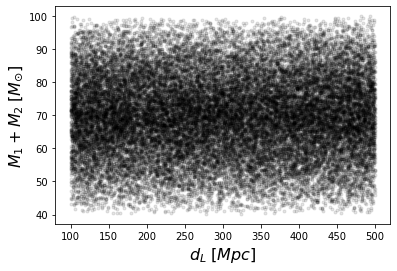

In [74]:
mtots = m1s+m2s
sg_mask = (y_trues == 1)
bg_mask = (y_trues == 0)
plt.plot(dists[sg_mask], mtots[sg_mask], ".", color='black', alpha=0.1, label='p')
plt.ylabel(r'$M_1 + M_2\;[M_{\odot}]$', size=16)
#plt.ylim([20.,1.e2])
plt.xlabel(r'$d_L\;[Mpc]$', size=16)
#plt.xlim([500.,1.e3])
plt.show()

In [30]:
def set_hist(h, xtitle, ytitle, htitle):
    #c.SetLeftMargin(0.16)
    #c.SetRightMargin(0.15)
    #c.SetBottomMargin(0.13)
    ROOT.gStyle.SetOptStat(0)

    h.GetXaxis().SetLabelSize(0.04)
    h.GetXaxis().SetLabelFont(42)
    h.GetXaxis().SetTitle(xtitle)
    h.GetXaxis().SetTitleOffset(0.09)
    h.GetXaxis().SetTitleSize(0.06)
    h.GetXaxis().SetTitleFont(42)

    h.GetYaxis().SetLabelSize(0.04)
    h.GetYaxis().SetLabelFont(42)
    h.GetYaxis().SetTitleOffset(1.2)
    h.GetYaxis().SetTitleSize(0.06)
    h.GetYaxis().SetTitleFont(42)
    h.GetYaxis().SetTitle(ytitle)

    h.SetTitleSize(0.04)
    h.SetTitleFont(62)
    h.SetTitle(htitle)
    h.SetTitleOffset(1.2)

    #return h, c
    return h

In [75]:
import LIGO_style
#tdrstyle.setTDRStyle()
ROOT.gStyle.SetPadTickX(1)
ROOT.gStyle.SetPadTickY(1)
#change the CMS_lumi variables (see CMS_lumi.py)
LIGO_style.writeExtraText = 1
LIGO_style.extraText = "Hanford"
LIGO_style.cmsTextOffset = 0.
t_total = 8*4096 # s
t_total_h = t_total//(60*60) # h
t_total_m = (t_total%(60*60))//60 # m
t_total_s = t_total_m%(60) # s
t_total_str = '%sh%sm%ss'%(t_total_h, t_total_h, t_total_s)
LIGO_style.lumi_sqrtS = "%s (O1)"%t_total_str # used with iPeriod = 0, e.g. for simulation-only plots (default is an empty string)
#iPos = 11 # inside frame
iPos = 0 # above frame
if iPos==0: LIGO_style.relPosX = 0.16
iPeriod = 0

In [76]:
h, c, hc = {}, {}, {}
line, legend = {}, {}
nbins = 20
wd, ht = int(480*1), int(420*1)

# bg
k = 'nn-bg'
c[k] = ROOT.TCanvas('c'+k, 'c'+k, wd, ht)
h[k] = ROOT.TH1F('h'+k, 'h'+k, nbins, 0., 1.)
for i in range(len(y_probs[bg_mask])):
    #if i > 1e4: break
    h[k].Fill(y_probs[bg_mask][i])

# sg
k = 'nn-sg'
h[k] = ROOT.TH1F('h'+k, 'h'+k, nbins, 0., 1.)
for i in range(len(y_probs[sg_mask])):
    #if i > 1e4: break
    h[k].Fill(y_probs[sg_mask][i])

0.05
9h9m6s (O1)


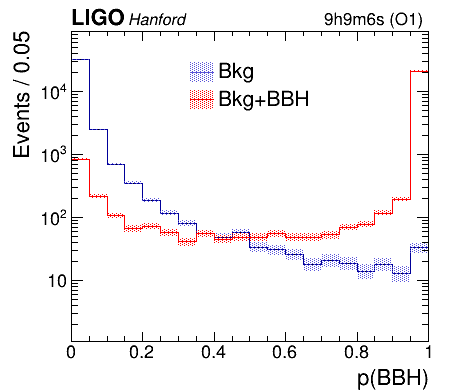

In [77]:
err_style = 'E2'
fill_style = 3002
LIGO_style.relPosX = 0.16
print(1./nbins)

k = 'nn-bg'
c[k].cd()
h[k] = set_hist(h[k], 'p(BBH)', 'Events / %3.2f'%(1./nbins), '')
ROOT.gPad.SetTopMargin(0.08)
ROOT.gPad.SetBottomMargin(0.13)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.1) # without colz
ROOT.TGaxis.fgMaxDigits = 3
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetErrorX(0.5)
ROOT.gPad.SetLogy()

ymin, ymax = 1.1e0, 9.e4
h[k].GetYaxis().SetRangeUser(ymin, ymax)
h[k].GetYaxis().SetTitleOffset(1.1)
h[k].GetYaxis().SetTitleSize(0.06)
h[k].GetYaxis().SetLabelSize(0.05)
h[k].GetYaxis().SetLabelFont(42)
h[k].GetYaxis().SetTitleFont(42)
h[k].GetYaxis().SetMaxDigits(3)

h[k].GetXaxis().SetTitleOffset(1.)
h[k].GetXaxis().SetTitleSize(0.06)
h[k].GetXaxis().SetLabelSize(0.05)
h[k].GetXaxis().SetLabelFont(42)
h[k].GetXaxis().SetTitleFont(42)
h[k].GetXaxis().SetNdivisions(-405)

# bg, line
h[k].Draw('hist')
# bg, band
hc[k] = h[k].Clone()
hc[k].SetName(k+'band')
hc[k].SetMarkerStyle(1)
hc[k].SetMarkerSize(0)
hc[k].SetLineColor(9)
hc[k].SetFillColor(9)
hc[k].SetFillStyle(fill_style)
hc[k].Draw("%s same"%err_style)

k = 'nn-sg'
# sg, line
h[k].SetLineColor(2)
h[k].Draw('hist same')
# sg, band
hc[k] = h[k].Clone()
hc[k].SetName(k+'band')
hc[k].SetMarkerStyle(1)
hc[k].SetMarkerSize(0)
hc[k].SetMarkerColor(2)
hc[k].SetLineColor(2)
hc[k].SetFillColor(2)
hc[k].SetFillStyle(fill_style)
hc[k].Draw("%s same"%err_style)

k = 'nn-bg'
legend[k] = ROOT.TLegend(0.39,0.71,0.39+0.28,0.85) #(x1, y1, x2, y2)
legend[k].AddEntry(hc['nn-bg'].GetName(), "Bkg", "lf")
legend[k].AddEntry(hc['nn-sg'].GetName(), "Bkg+BBH", "lf")
legend[k].SetBorderSize(0)
legend[k].SetTextFont(42)
legend[k].Draw("same")

c[k].RedrawAxis()
c[k].Draw()

LIGO_style.LIGO_style(c[k], iPeriod, iPos)

In [78]:
from array import array

fprinv_edges = (1./fpr_edges)[::-1]
fprinv_edges[-1] = 1.e5
print(fprinv_edges)

hsg = sg_thr[::-1]
print(hsg)
hbg = bg_thr[::-1]
print(hbg)
# NOTE: in this binning, bin_val | edge_i < bin_val <= edge_i+1
# i.e. inclusive on upper edge, rather than on lower edge, so that
# (1) top bg scores are histogrammed below FPinv max
# (2) top sg scores dont go into overflow bin
nbins = len(fprinv_edges)-1
fprinv_edges = array('d', fprinv_edges)

h, c = {}, {}

k = 'nsgvfprinv'
h[k] = ROOT.TH1F(k, k, nbins, fprinv_edges)

k = 'nbgvfprinv'
c[k] = ROOT.TCanvas('c'+k, 'c'+k, 480, 420)
h[k] = ROOT.TH1F(k, k, nbins, fprinv_edges)

for i in range(nbins):
    h['nsgvfprinv'].SetBinContent(i+1, hsg[i])
    h['nbgvfprinv'].SetBinContent(i+1, hbg[i])

[1.00000000e+00 2.59520049e+00 6.73506560e+00 1.74788456e+01
 4.53611086e+01 1.17721171e+02 3.05510042e+02 7.92859811e+02
 2.05763017e+03 5.33996284e+03 1.38582742e+04 3.59650000e+04
 1.00000000e+05]
[  462   312   248   187   248   278   324   635   572  3332  3985 25438
     0]
[22081  8543  3280  1266   489   186    74    28    11     4     2     0
     0]


/export/home/phys/mbandrews/miniconda3/envs/gw-pyt/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cnbgvfprinv


9h9m6s (O1)


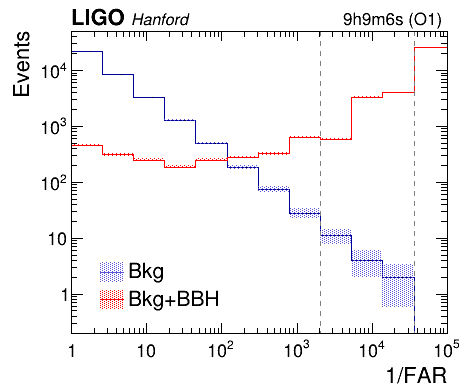

In [79]:
err_style = 'E2'
fill_style = 3002
LIGO_style.relPosX = 0.16

k = 'nbgvfprinv'
c[k].cd()
#h[k] = set_hist(h[k], 'FAR^{-1}', 'Events', '')
h[k] = set_hist(h[k], '1/FAR', 'Events', '')
ROOT.gPad.SetTopMargin(0.08)
ROOT.gPad.SetBottomMargin(0.15)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.06) # without colz
ROOT.TGaxis.fgMaxDigits = 3
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetErrorX(0.5)
ROOT.gPad.SetLogx()
ROOT.gPad.SetLogy()

ymin, ymax = 2.e-1, 5.e4
h[k].GetYaxis().SetRangeUser(ymin, ymax)
h[k].GetYaxis().SetTitleOffset(1.1)
h[k].GetYaxis().SetTitleSize(0.06)
h[k].GetYaxis().SetLabelSize(0.05)
h[k].GetYaxis().SetLabelFont(42)
h[k].GetYaxis().SetTitleFont(42)
h[k].GetYaxis().SetMaxDigits(3)

h[k].GetXaxis().SetTitleOffset(1.1)
h[k].GetXaxis().SetTitleSize(0.06)
h[k].GetXaxis().SetLabelSize(0.05)
h[k].GetXaxis().SetLabelFont(42)
h[k].GetXaxis().SetTitleFont(42)
h[k].GetXaxis().SetNdivisions(-405)

# bg, line
h[k].Draw('hist')
# bg, band
hc[k] = h[k].Clone()
hc[k].SetName(k+'band')
hc[k].SetMarkerStyle(1)
hc[k].SetMarkerSize(0)
hc[k].SetLineColor(9)
hc[k].SetFillColor(9)
hc[k].SetFillStyle(fill_style)
hc[k].Draw("%s same"%err_style)

k = 'nsgvfprinv'
# sg, line
h[k].SetLineColor(2)
h[k].Draw('hist same')
# sg, band
hc[k] = h[k].Clone()
hc[k].SetName(k+'band')
hc[k].SetMarkerStyle(1)
hc[k].SetMarkerSize(0)
hc[k].SetMarkerColor(2)
hc[k].SetLineColor(2)
hc[k].SetFillColor(2)
hc[k].SetFillStyle(fill_style)
hc[k].Draw("%s same"%err_style)

k = 'nbgvfprinv'
legend[k] = ROOT.TLegend(0.2,0.2,0.2+0.28,0.2+0.14) #(x1, y1, x2, y2)
legend[k].AddEntry(hc['nbgvfprinv'].GetName(), "Bkg",     "lf")
legend[k].AddEntry(hc['nsgvfprinv'].GetName(), "Bkg+BBH", "lf")
legend[k].SetBorderSize(0)
legend[k].SetTextFont(42)
legend[k].Draw("same")

kl1 = k+'l1'
line[kl1] = ROOT.TLine(fprinv_edges[-5], 0., fprinv_edges[-5], ymax) # x0,y0, x1,y1
line[kl1].SetLineColor(14)
line[kl1].SetLineStyle(7)
line[kl1].Draw("same")

kl2 = k+'l2'
line[kl2] = ROOT.TLine(fprinv_max, 0., fprinv_max, ymax) # x0,y0, x1,y1
line[kl2].SetLineColor(14)
line[kl2].SetLineStyle(7)
line[kl2].Draw("same")

c[k].RedrawAxis()
c[k].Draw()

LIGO_style.LIGO_style(c[k], iPeriod, iPos)

In [86]:
wd, ht = int(480*1), int(400*1)

thr_fprinv_glitch = 0.96222246

k = 'sgeffFPRinvmax'
c[k] = ROOT.TCanvas('c'+k, 'c'+k, wd, ht)
h[k] = ROOT.TProfile2D('h'+k, 'h'+k, 10, 100, 500, 10, 40, 100)
dists_sg = dists[sg_mask]
mtots_sg = mtots[sg_mask]
y_probs_sg = y_probs[sg_mask]
for i in range(len(mtots[sg_mask])):
    # high-purity regime
    h[k].Fill(dists_sg[i], mtots_sg[i], 1. if y_probs_sg[i] > thr_fprinvmax else 0.)
    # glitch regime
    #h[k].Fill(dists_sg[i], mtots_sg[i], 1. if (y_probs_sg[i] < thr_fprinvmax and y_probs_sg[i] >= thr_fprinv_glitch) else 0.)
    # nois regime
    #h[k].Fill(dists_sg[i], mtots_sg[i], 1. if y_probs_sg[i] < thr_fprinv_glitch else 0.)

print(h[k].GetMinimum(), h[k].GetMaximum())

0.07142857142857142 0.9633204633204633


Warning in <TCanvas::Constructor>: Deleting canvas with same name: csgeffFPRinvmax
Warning in <TROOT::Append>: Replacing existing TH1: hsgeffFPRinvmax (Potential memory leak).


9h9m6s (O1)


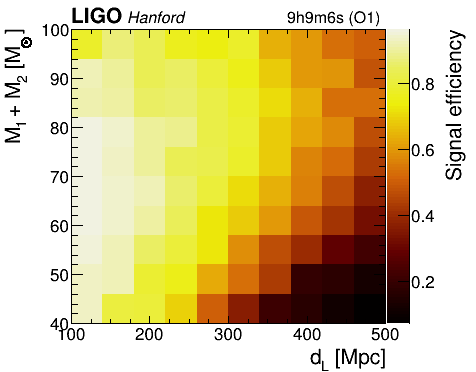

In [87]:
if iPos==0: LIGO_style.relPosX = 0.18

k = 'sgeffFPRinvmax'

c[k].cd()
h[k] = set_hist(h[k], 'd_{L} [Mpc]', 'M_{1} + M_{2} [M_{#odot} ]', '')
ROOT.gPad.SetTopMargin(0.08)
ROOT.gPad.SetBottomMargin(0.13)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.19) # with colz
#ROOT.gPad.SetRightMargin(0.1) # without colz
ROOT.gStyle.SetPalette(53)#53:kDarkBodyRadiator, 51:kDeepSea
ROOT.TGaxis.fgMaxDigits = 3
ROOT.gStyle.SetOptStat(0)
ROOT.gPad.SetLogz(0) #0:set False, 1:set True

ymin, ymax = 40., 100.
h[k].GetYaxis().SetRangeUser(ymin, ymax)
h[k].GetYaxis().SetTitleOffset(1.2)
h[k].GetYaxis().SetTitleSize(0.06)
h[k].GetYaxis().SetLabelSize(0.05)
h[k].GetYaxis().SetLabelFont(42)
h[k].GetYaxis().SetTitleFont(42)

h[k].GetXaxis().SetTitleOffset(1.0)
h[k].GetXaxis().SetTitleSize(0.06)
h[k].GetXaxis().SetLabelSize(0.05)
h[k].GetXaxis().SetLabelFont(42)
h[k].GetXaxis().SetTitleFont(42)
h[k].GetXaxis().SetNdivisions(-404)

h[k].GetZaxis().SetTitle('Signal efficiency')
h[k].GetZaxis().SetTitleOffset(1.)
h[k].GetZaxis().SetTitleSize(0.06)
h[k].GetZaxis().SetLabelSize(0.05)
h[k].GetZaxis().SetTitleFont(42)
h[k].GetZaxis().SetLabelFont(42)
h[k].GetZaxis().SetNdivisions(6)

#h[k].SetMaximum(0.55)
#h[k].SetMinimum(0.)
h[k].SetContour(100)

h[k].Draw('COLZ')
c[k].Draw()

LIGO_style.LIGO_style(c[k], iPeriod, iPos)

In [124]:
wd, ht = int(480*1), int(400*1)

k = 'limits'
c[k] = ROOT.TCanvas('c'+k, 'c'+k, wd, ht)
#h[k] = ROOT.TProfile2D('h'+k, 'h'+k, 10, 500, 1.e3, 10, 20, 100)
h[k] = ROOT.TProfile2D('h'+k, 'h'+k, 10, 100, 500, 10, 40, 100)
for i in range(len(mtots[sg_mask])):
    h[k].Fill(dists[sg_mask][i], mtots[sg_mask][i], y_probs[sg_mask][i])

9h9m6s (O1)


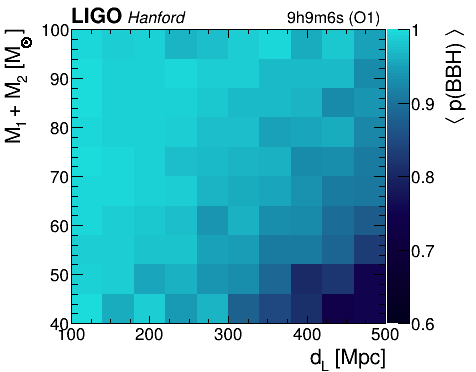

In [125]:
if iPos==0: LIGO_style.relPosX = 0.18

k = 'limits'

c[k].cd()
h[k] = set_hist(h[k], 'd_{L} [Mpc]', 'M_{1} + M_{2} [M_{#odot} ]', '')
ROOT.gPad.SetTopMargin(0.08)
ROOT.gPad.SetBottomMargin(0.13)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.19) # with colz
#ROOT.gPad.SetRightMargin(0.1) # without colz
ROOT.gStyle.SetPalette(51)#53
ROOT.TGaxis.fgMaxDigits = 3
ROOT.gStyle.SetOptStat(0)

ymin, ymax = 40., 100.
h[k].GetYaxis().SetRangeUser(ymin, ymax)
h[k].GetYaxis().SetTitleOffset(1.2)
h[k].GetYaxis().SetTitleSize(0.06)
h[k].GetYaxis().SetLabelSize(0.05)
h[k].GetYaxis().SetLabelFont(42)
h[k].GetYaxis().SetTitleFont(42)

h[k].GetZaxis().SetTitle('#LT p(BBH) #GT')
h[k].GetZaxis().SetTitleOffset(1.)
h[k].GetZaxis().SetTitleSize(0.06)
h[k].GetZaxis().SetLabelSize(0.05)
h[k].GetZaxis().SetTitleFont(42)
h[k].GetZaxis().SetLabelFont(42)
h[k].GetZaxis().SetNdivisions(-4)

h[k].GetXaxis().SetTitleOffset(1.0)
h[k].GetXaxis().SetTitleSize(0.06)
h[k].GetXaxis().SetLabelSize(0.05)
h[k].GetXaxis().SetLabelFont(42)
h[k].GetXaxis().SetTitleFont(42)
h[k].GetXaxis().SetNdivisions(-404)

h[k].SetMaximum(1.)
h[k].SetMinimum(0.6)
h[k].SetContour(100)

h[k].Draw('COLZ')
c[k].Draw()

LIGO_style.LIGO_style(c[k], iPeriod, iPos)